Data taken from GEO Series [`GSE267327`](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE267327)

**Title:** 	Tumor-Infiltrating CTL expansion and effector functions depends on Slc7a5-dependent tryptophan update that's Public on May 17, 2025

# Preprocessing and clustering

In [1]:
# Core scverse libraries
import scanpy as sc
import anndata as ad

In [2]:
sc.settings.set_figure_params(dpi=50, facecolor="white")

In [3]:
samples = {
    "ATL-1": "GSM8263927_ATL-1_filtered_feature_bc_matrix.h5",
    "ATL-2": "GSM8263928_ATL-2_filtered_feature_bc_matrix.h5",
    "ATL-3": "GSM8263929_ATL-3_filtered_feature_bc_matrix.h5",
    "ATL-4": "GSM8263930_ATL-4_filtered_feature_bc_matrix.h5",
    "ATL-5": "GSM8263931_ATL-5_filtered_feature_bc_matrix.h5",
    "HD-1": "GSM8263932_HD-1_filtered_feature_bc_matrix.h5",
    "HD-2": "GSM8263933_HD-2_filtered_feature_bc_matrix.h5",
    "HD-3": "GSM8263934_HD-3_filtered_feature_bc_matrix.h5",
}

adatas = {}

for sample_id, filename in samples.items():
    path = (filename)
    sample_adata = sc.read_10x_h5(path)
    sample_adata.var_names_make_unique()
    adatas[sample_id] = sample_adata

adata = ad.concat(adatas, label="sample")
adata.obs_names_make_unique()
print(adata.obs["sample"].value_counts())
adata

/home/igris/py/lib/python3.12/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/igris/py/lib/python3.12/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/igris/py/lib/python3.12/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/igris/py/lib/python3.12/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/igris/py/lib/python3.12/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique

sample
ATL-3    7966
HD-3     7146
ATL-5    6880
HD-1     6271
HD-2     5598
ATL-2    5334
ATL-1    5090
ATL-4    4941
Name: count, dtype: int64


/home/igris/py/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


AnnData object with n_obs × n_vars = 49226 × 36601
    obs: 'sample'

## Quality Control

In [4]:
# mitochondrial genes, "MT-" for human, "Mt-" for mouse
adata.var["mt"] = adata.var_names.str.startswith("MT-")
# ribosomal genes
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
# hemoglobin genes
adata.var["hb"] = adata.var_names.str.contains("^HB[^(P)]")

In [5]:
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt", "ribo", "hb"], inplace=True, log1p=True
)

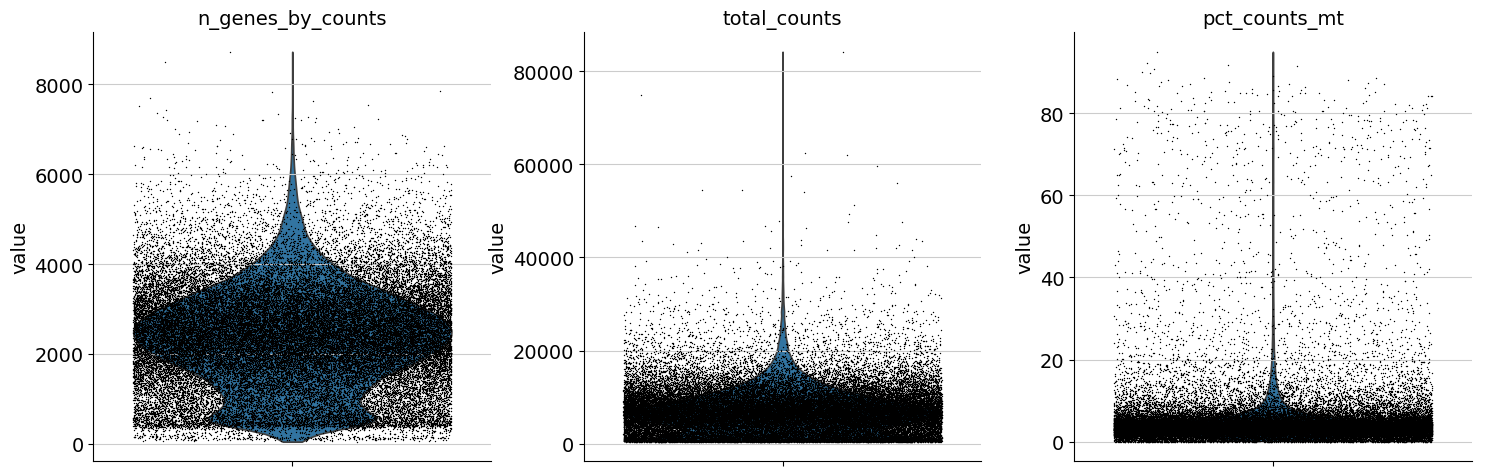

In [6]:
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)

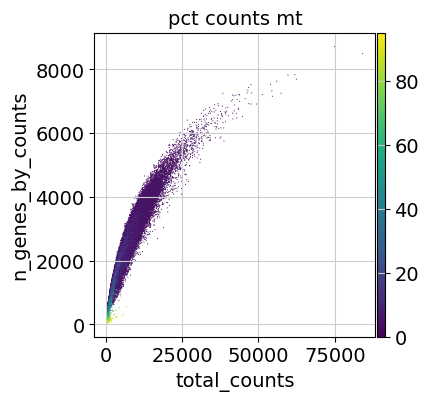

In [7]:
sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

In [8]:
sc.pp.filter_cells(adata, min_genes=100)
sc.pp.filter_genes(adata, min_cells=3)

### Doublet detection

In [9]:
sc.pp.scrublet(adata, batch_key="sample")

## Normalization

In [10]:
# Saving count data
adata.layers["counts"] = adata.X.copy()

In [11]:
# Normalizing to median total counts
sc.pp.normalize_total(adata)
# Logarithmize the data
sc.pp.log1p(adata)

## Feature selection

In [12]:
sc.pp.highly_variable_genes(adata, n_top_genes=2000, batch_key="sample")

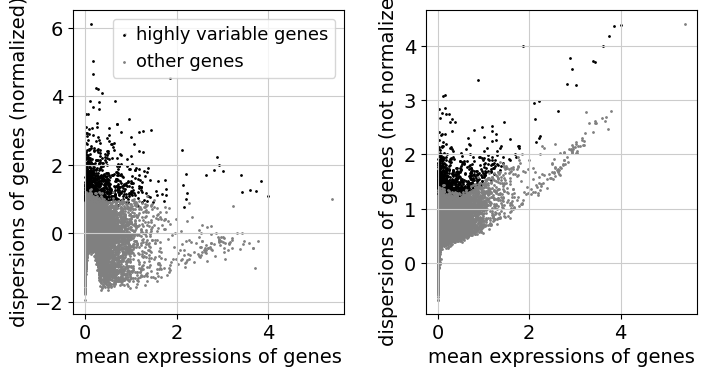

In [13]:
sc.pl.highly_variable_genes(adata)

## Dimensionality Reduction

In [14]:
sc.tl.pca(adata)

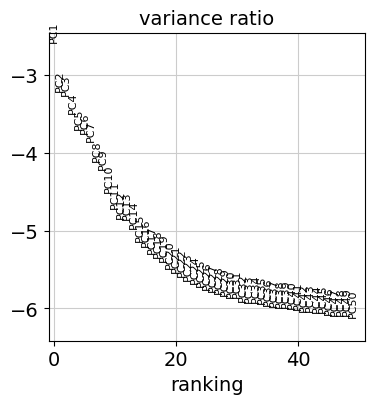

In [15]:
sc.pl.pca_variance_ratio(adata, n_pcs=50, log=True)

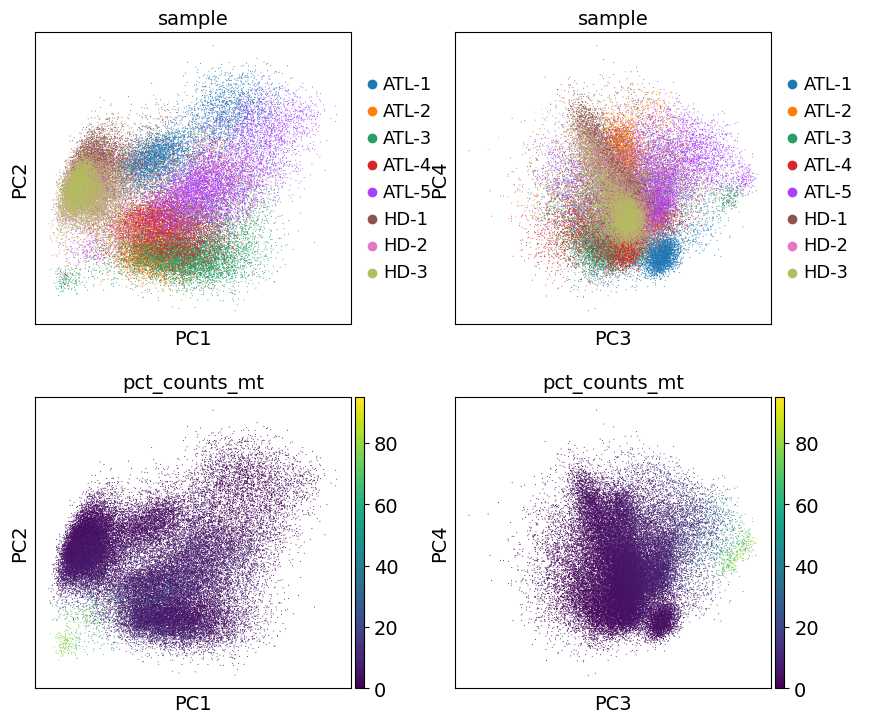

In [16]:
sc.pl.pca(
    adata,
    color=["sample", "sample", "pct_counts_mt", "pct_counts_mt"],
    dimensions=[(0, 1), (2, 3), (0, 1), (2, 3)],
    ncols=2,
    size=2,
)

## Nearest neighbor graph constuction and visualization

In [17]:
sc.pp.neighbors(adata)

2025-05-20 19:00:50.068280: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747747850.278098    5014 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747747850.310259    5014 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747747850.656414    5014 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747747850.656461    5014 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747747850.656468    5014 computation_placer.cc:177] computation placer alr

In [18]:
sc.tl.umap(adata)

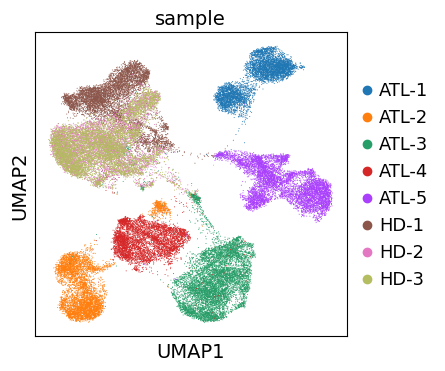

In [19]:
sc.pl.umap(
    adata,
    color="sample",
    # Setting a smaller point size to get prevent overlap
    size=2,
)

## Clustering

In [20]:
# Using the igraph implementation and a fixed number of iterations can be significantly faster, especially for larger datasets
sc.tl.leiden(adata, flavor="igraph", n_iterations=2)

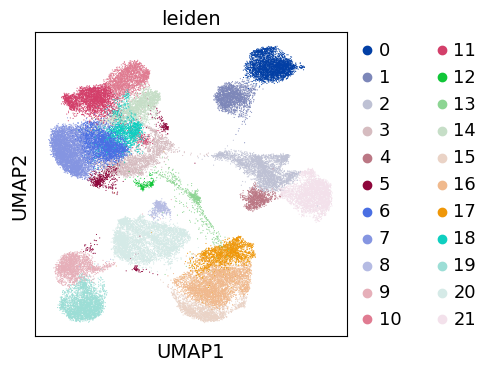

In [21]:
sc.pl.umap(adata, color=["leiden"])

## Re-assess quality control and cell filtering 

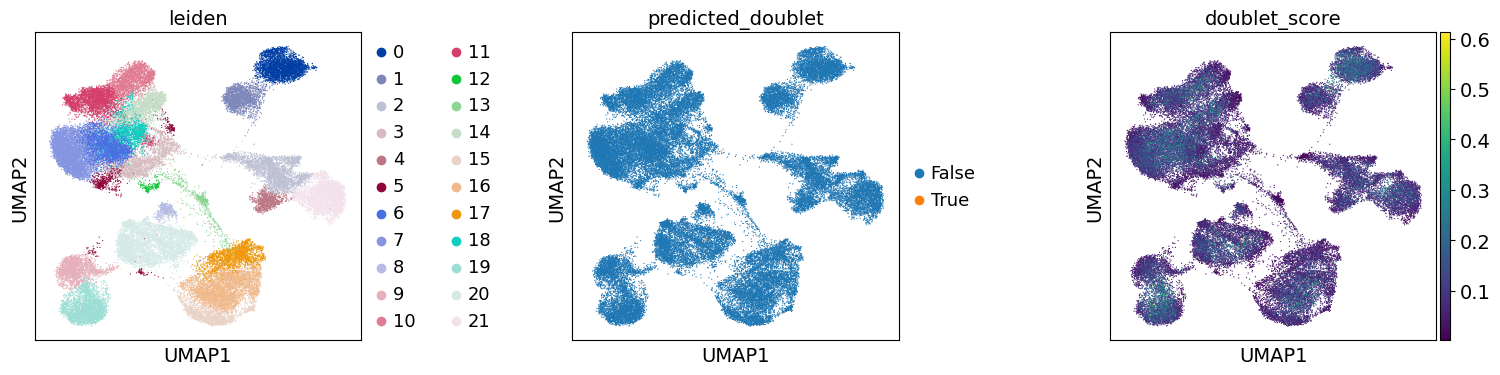

In [22]:
sc.pl.umap(
    adata,
    color=["leiden", "predicted_doublet", "doublet_score"],
    # increase horizontal space between panels
    wspace=0.5,
    size=3,
)

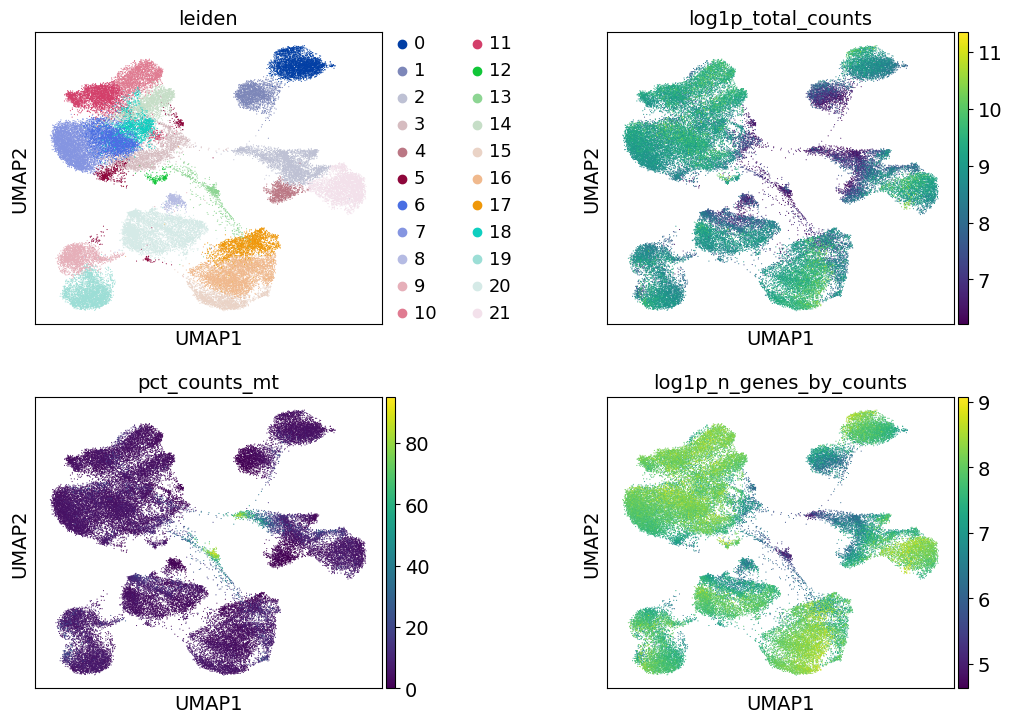

In [23]:
sc.pl.umap(
    adata,
    color=["leiden", "log1p_total_counts", "pct_counts_mt", "log1p_n_genes_by_counts"],
    wspace=0.5,
    ncols=2,
)

In [24]:
sc.tl.rank_genes_groups(adata, groupby="leiden", method="wilcoxon")

/home/igris/py/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:458: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "names"] = self.var_names[global_indices]
/home/igris/py/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:460: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "scores"] = scores[global_indices]
/home/igris/py/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:463: PerformanceWarning: DataFrame is highly fragmented.  This is usuall

In [25]:
sc.get.rank_genes_groups_df(adata, group="7").head(5)

names     scores  logfoldchanges  pvals  pvals_adj
0       FHIT  91.432213        4.085418    0.0        0.0
1  PRKCQ-AS1  85.954453        2.844716    0.0        0.0
2      RPL34  82.270660        1.885593    0.0        0.0
3      RPS3A  80.952980        1.819402    0.0        0.0
4      RPS14  79.804459        1.763896    0.0        0.0

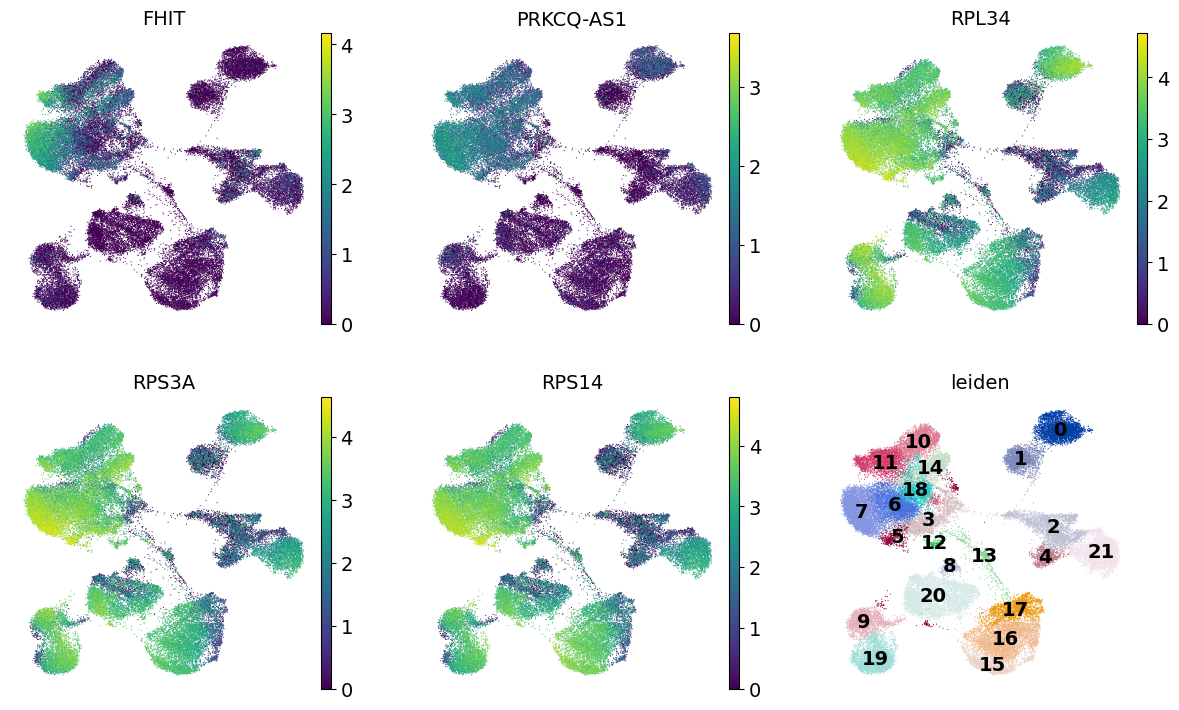

In [26]:
dc_cluster_genes = sc.get.rank_genes_groups_df(adata, group="7").head(5)["names"]
sc.pl.umap(
    adata,
    color=[*dc_cluster_genes, "leiden"],
    legend_loc="on data",
    frameon=False,
    ncols=3,
)

## Visualization of gene expression and other variables

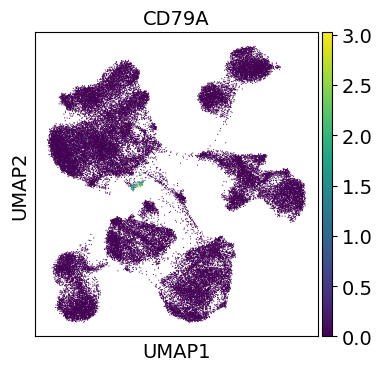

In [27]:
from matplotlib.pyplot import rc_context
with rc_context({"figure.figsize": (4, 4)}):
    sc.pl.umap(adata, color="CD79A")

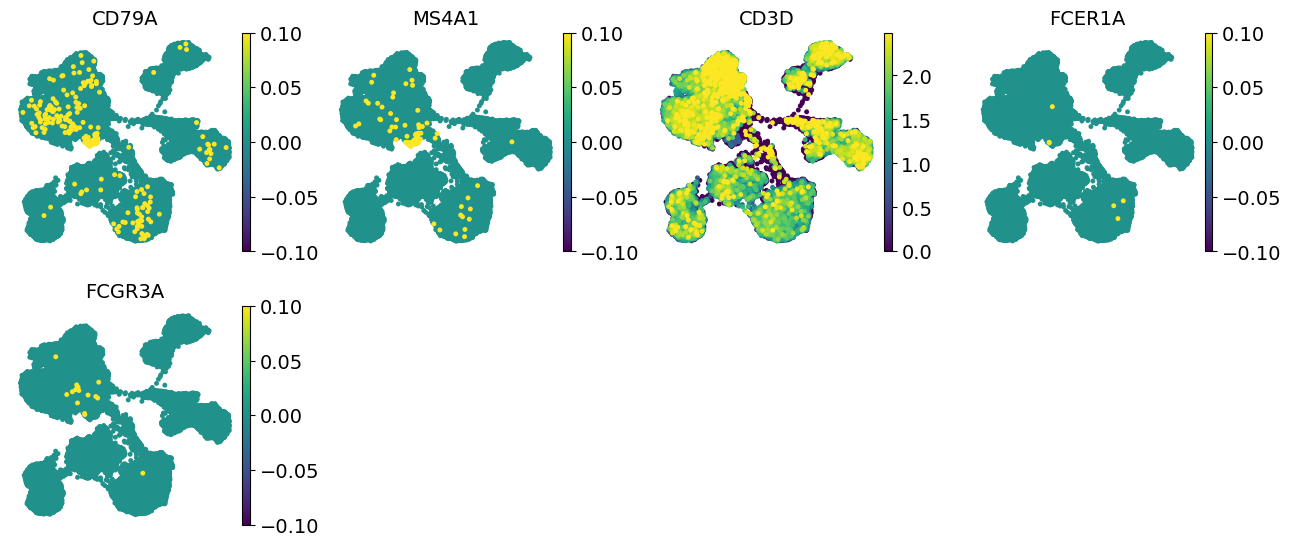

In [28]:
color_vars = [
    "CD79A",
    "MS4A1",
    "CD3D",
    "FCER1A",
    "FCGR3A",
]
with rc_context({"figure.figsize": (3, 3)}):
    sc.pl.umap(adata, color=color_vars, s=50, frameon=False, ncols=4, vmax="p99")

In [29]:
sc.tl.leiden(
    adata,
    key_added="clusters",
    resolution=0.5,
    n_iterations=2,
    flavor="igraph",
    directed=False,
)

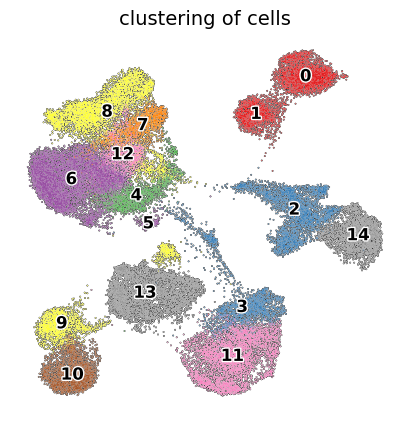

In [30]:
with rc_context({"figure.figsize": (5, 5)}):
    sc.pl.umap(
        adata,
        color="clusters",
        add_outline=True,
        legend_loc="on data",
        legend_fontsize=12,
        legend_fontoutline=2,
        frameon=False,
        title="clustering of cells",
        palette="Set1",
    )

## Identification of clusters based on known marker genes

In [31]:
marker_genes_dict = {
    "B-cell": ["CD79A", "MS4A1"],
    "Dendritic": ["FCER1A", "CST3"],
    "Monocytes": ["FCGR3A"],
    "NK": ["GNLY", "NKG7"],
    "Other": ["IGLL1"],
    "T-cell": ["CD3D"],
}

## dotplot

categories: 0, 1, 2, etc.
var_group_labels: B-cell, Dendritic, Monocytes, etc.


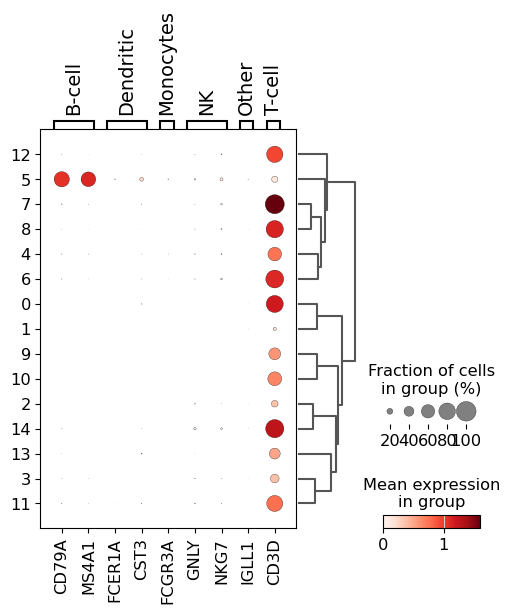

In [32]:
sc.pl.dotplot(adata, marker_genes_dict, "clusters", dendrogram=True)

In [33]:
cluster2annotation = {
    "0": "Monocytes",
    "1": "NK",
    "2": "T-cell",
    "3": "Dendritic",
    "4": "Dendritic",
    "5": "Plasma",
    "6": "B-cell",
    "7": "Dendritic",
    "8": "Other",
}

adata.obs["cell type"] = adata.obs["clusters"].map(cluster2annotation).astype("category")

categories: B-cell, Dendritic, Monocytes, etc.
var_group_labels: B-cell, Dendritic, Monocytes, etc.


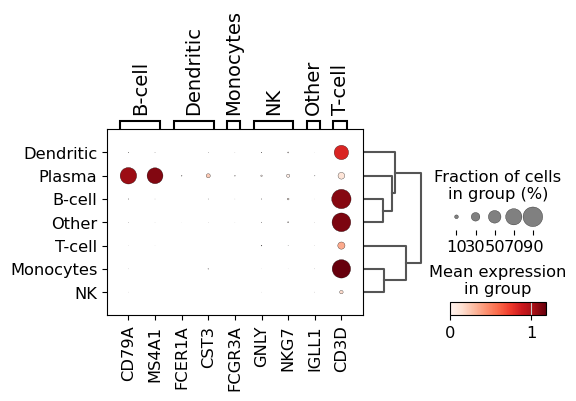

In [34]:
sc.pl.dotplot(adata, marker_genes_dict, "cell type", dendrogram=True)

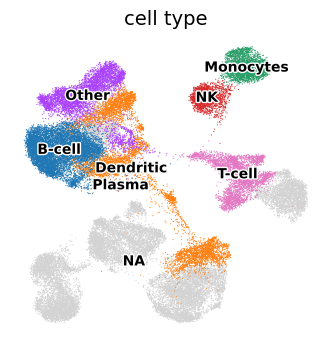

In [35]:
sc.pl.umap(
    adata,
    color="cell type",
    legend_loc="on data",
    frameon=False,
    legend_fontsize=10,
    legend_fontoutline=2,
)

## violin plot

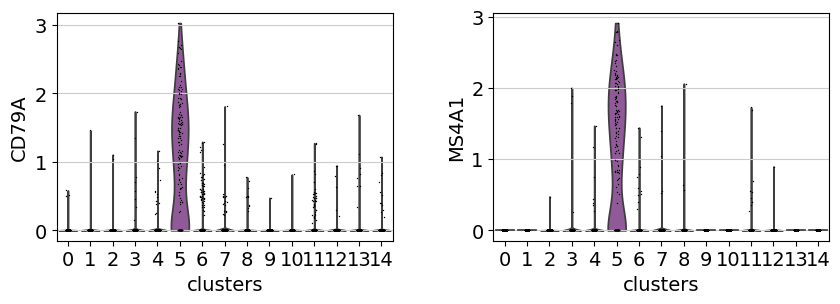

In [36]:
with rc_context({"figure.figsize": (4.5, 3)}):
    sc.pl.violin(adata, ["CD79A", "MS4A1"], groupby="clusters")

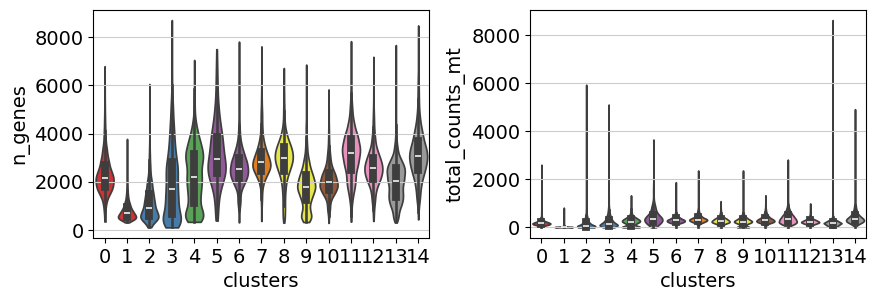

In [37]:
with rc_context({"figure.figsize": (4.5, 3)}):
    sc.pl.violin(
        adata,
        ["n_genes", "total_counts_mt"],
        groupby="clusters",
        stripplot=False,
        inner="box",
    )

## stacked-violin plot

categories: 0, 1, 2, etc.
var_group_labels: B-cell, Dendritic, Monocytes, etc.


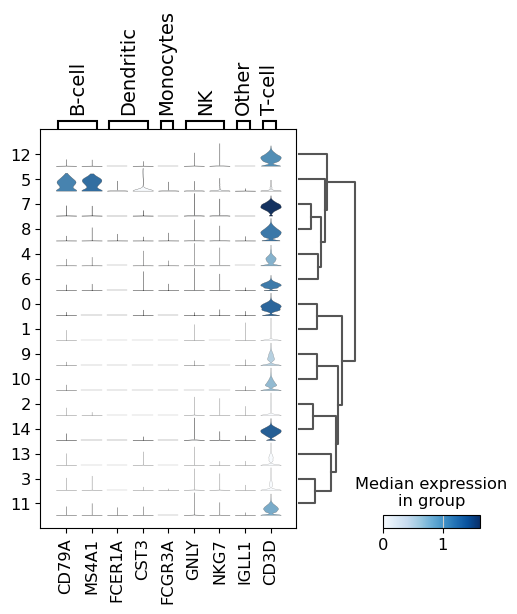

In [38]:
ax = sc.pl.stacked_violin(
    adata, marker_genes_dict, groupby="clusters", swap_axes=False, dendrogram=True
)

## matrixplot

categories: 0, 1, 2, etc.
var_group_labels: B-cell, Dendritic, Monocytes, etc.


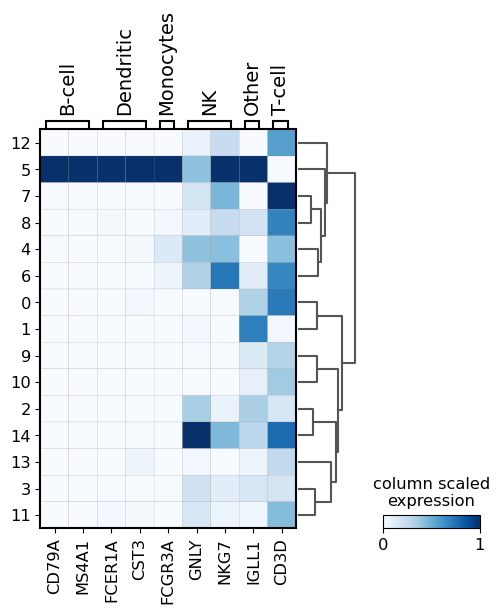

In [39]:
sc.pl.matrixplot(
    adata,
    marker_genes_dict,
    "clusters",
    dendrogram=True,
    cmap="Blues",
    standard_scale="var",
    colorbar_title="column scaled\nexpression",
)

In [40]:
adata.layers["scaled"] = sc.pp.scale(adata, copy=True).X

categories: 0, 1, 2, etc.
var_group_labels: B-cell, Dendritic, Monocytes, etc.


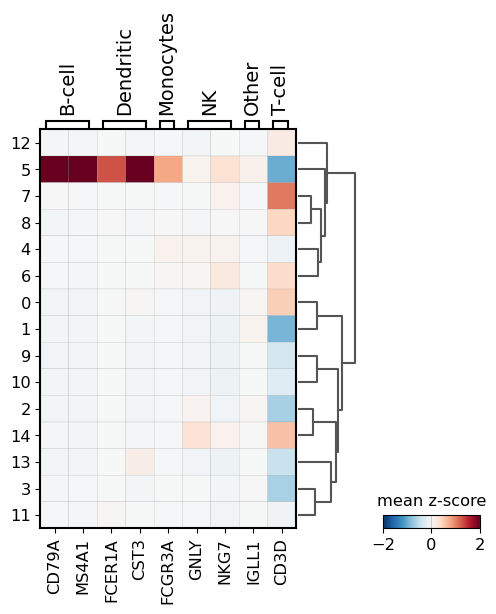

In [41]:
sc.pl.matrixplot(
    adata,
    marker_genes_dict,
    "clusters",
    dendrogram=True,
    colorbar_title="mean z-score",
    layer="scaled",
    vmin=-2,
    vmax=2,
    cmap="RdBu_r",
)

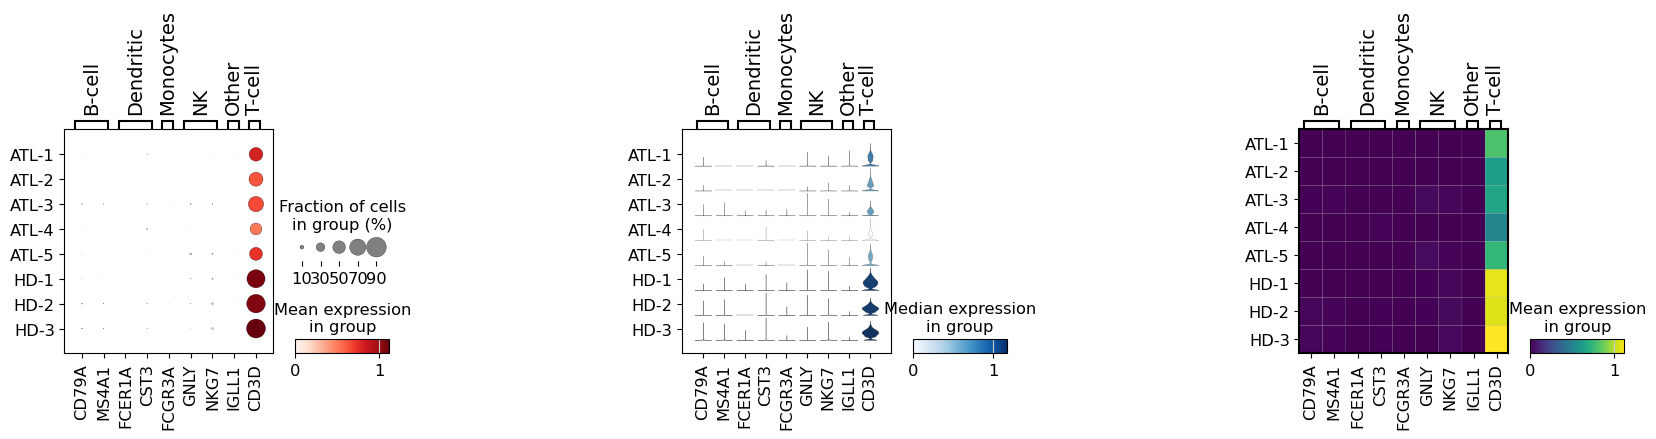

In [42]:
import matplotlib.pyplot as plt

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 4), gridspec_kw={"wspace": 0.9})

ax1_dict = sc.pl.dotplot(
    adata, marker_genes_dict, groupby="sample", ax=ax1, show=False
)
ax2_dict = sc.pl.stacked_violin(
    adata, marker_genes_dict, groupby="sample", ax=ax2, show=False
)
ax3_dict = sc.pl.matrixplot(
    adata, marker_genes_dict, groupby="sample", ax=ax3, show=False, cmap="viridis"
)

## Heatmaps

categories: 0, 1, 2, etc.
var_group_labels: B-cell, Dendritic, Monocytes, etc.


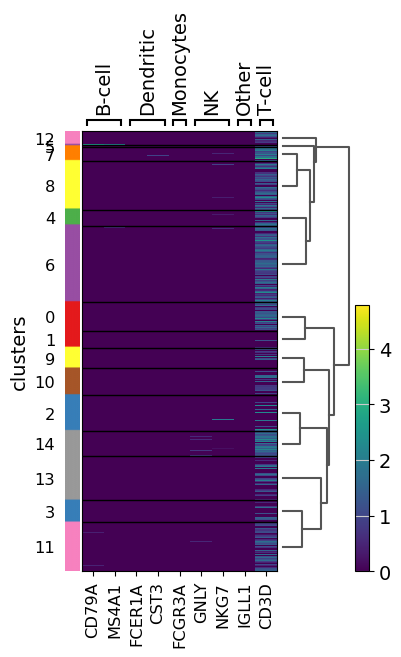

In [43]:
ax = sc.pl.heatmap(
    adata, marker_genes_dict, groupby="clusters", cmap="viridis", dendrogram=True
)

categories: 0, 1, 2, etc.
var_group_labels: B-cell, Dendritic, Monocytes, etc.


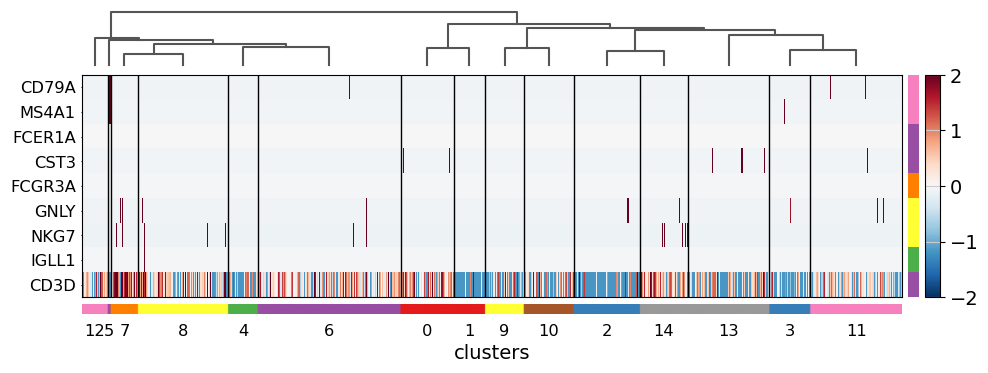

In [44]:
ax = sc.pl.heatmap(
    adata,
    marker_genes_dict,
    groupby="clusters",
    layer="scaled",
    vmin=-2,
    vmax=2,
    cmap="RdBu_r",
    dendrogram=True,
    swap_axes=True,
    figsize=(11, 4),
)

categories: 0, 1, 2, etc.
var_group_labels: B-cell, Dendritic, Monocytes, etc.


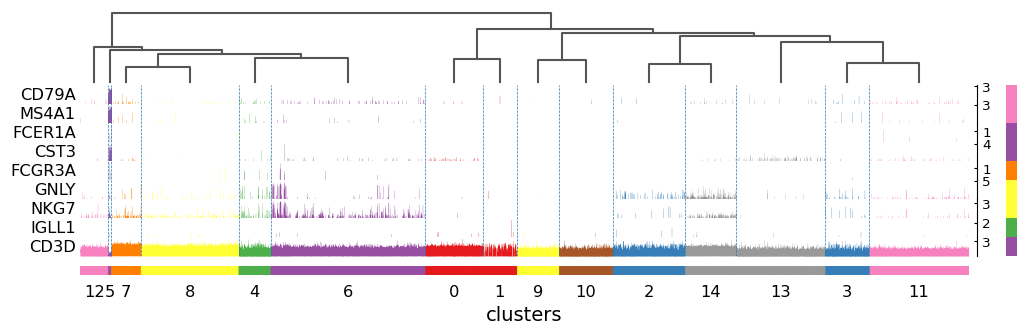

In [45]:
ax = sc.pl.tracksplot(adata, marker_genes_dict, groupby="clusters", dendrogram=True)

## Visualization of marker genes

In [46]:
sc.tl.rank_genes_groups(adata, groupby="clusters", method="wilcoxon")

## Visualize marker genes using dotplot

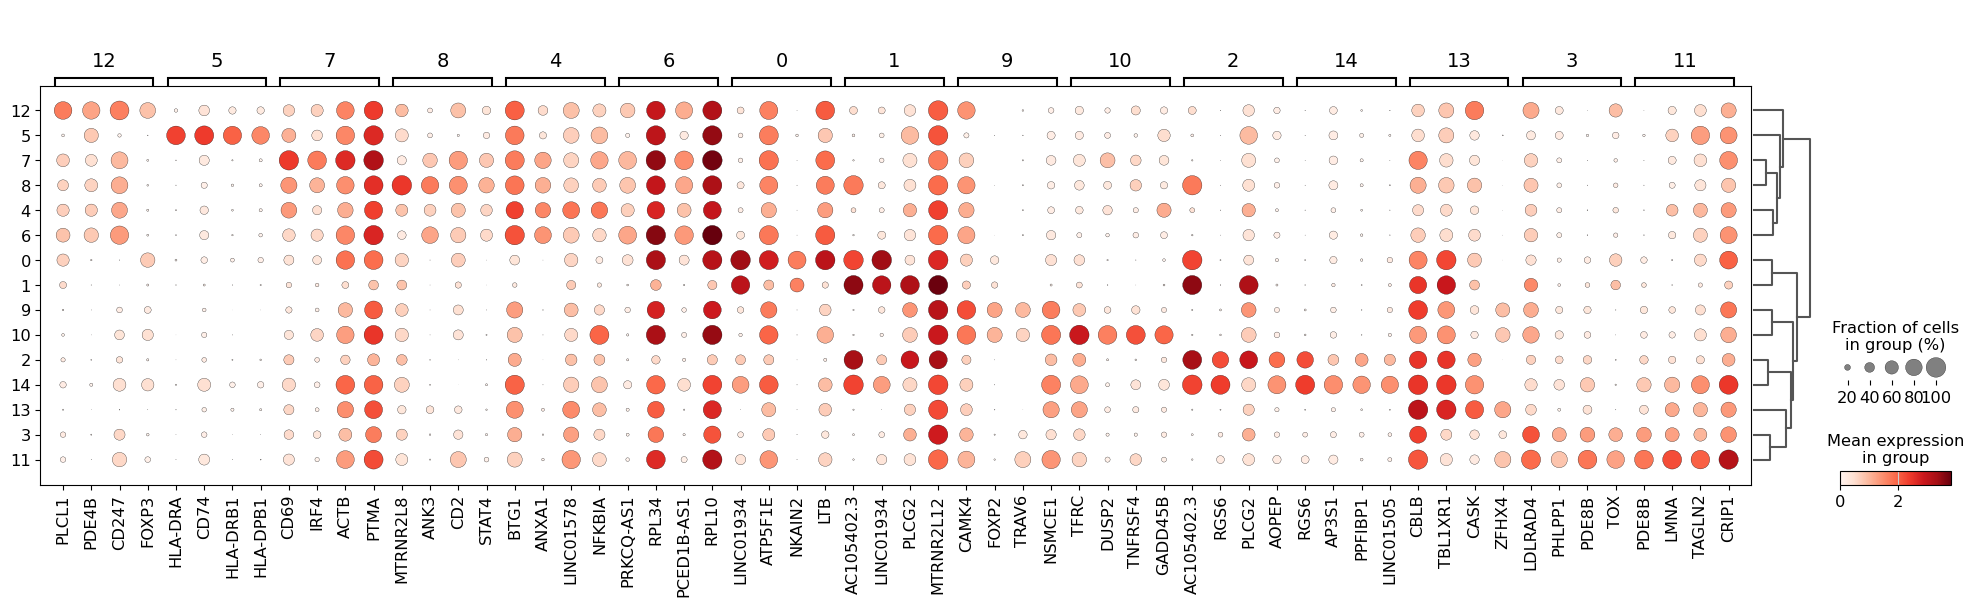

In [47]:
sc.pl.rank_genes_groups_dotplot(adata, n_genes=4)

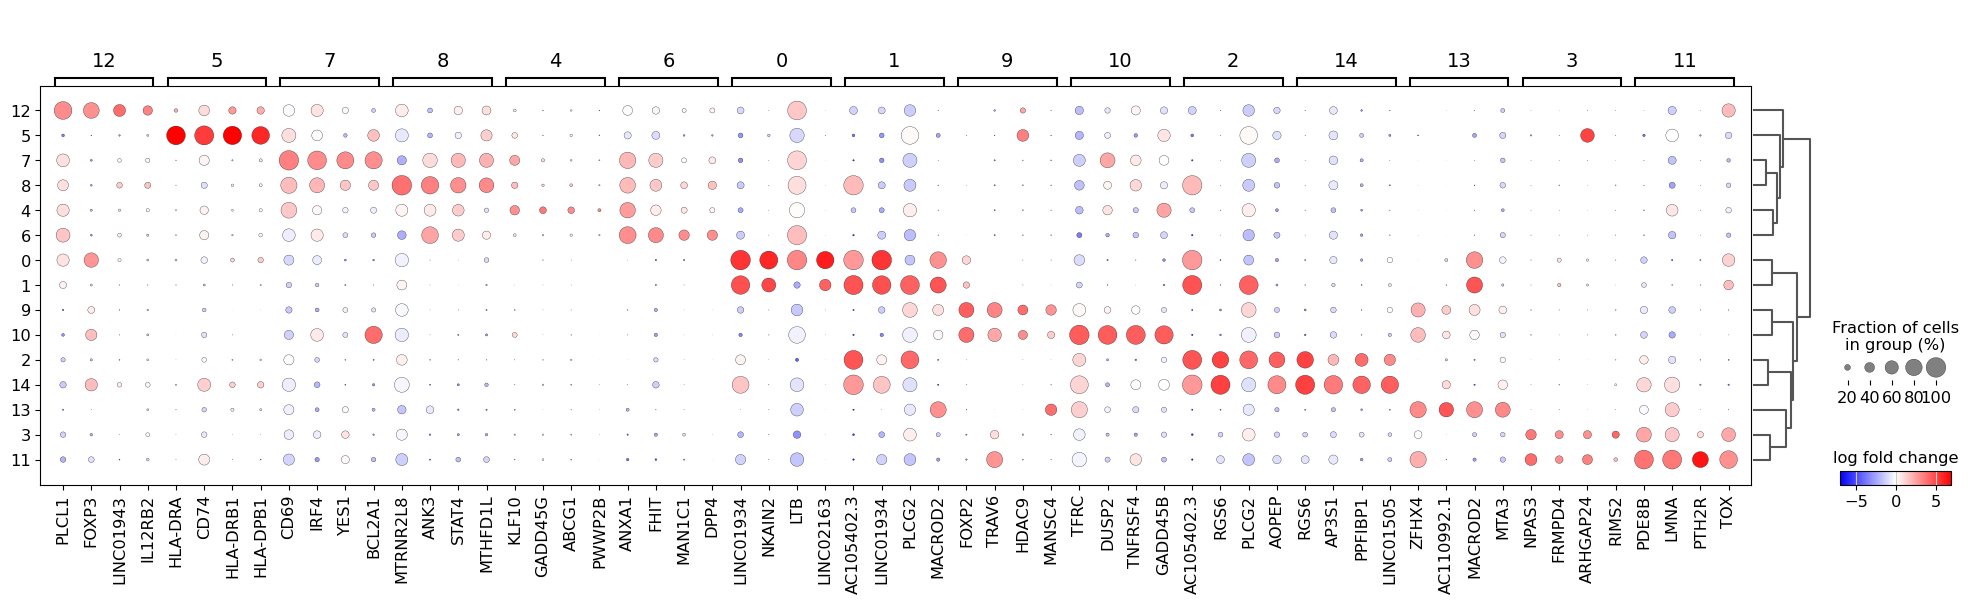

In [48]:
sc.pl.rank_genes_groups_dotplot(
    adata,
    n_genes=4,
    values_to_plot="logfoldchanges",
    min_logfoldchange=3,
    vmax=7,
    vmin=-7,
    cmap="bwr",
)

## Focusing on particular groups

/home/igris/py/lib/python3.12/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: divide by zero encountered in log10
  result = func(self.values, **kwargs)


categories: 0, 1, 2, etc.
var_group_labels: 3, 7


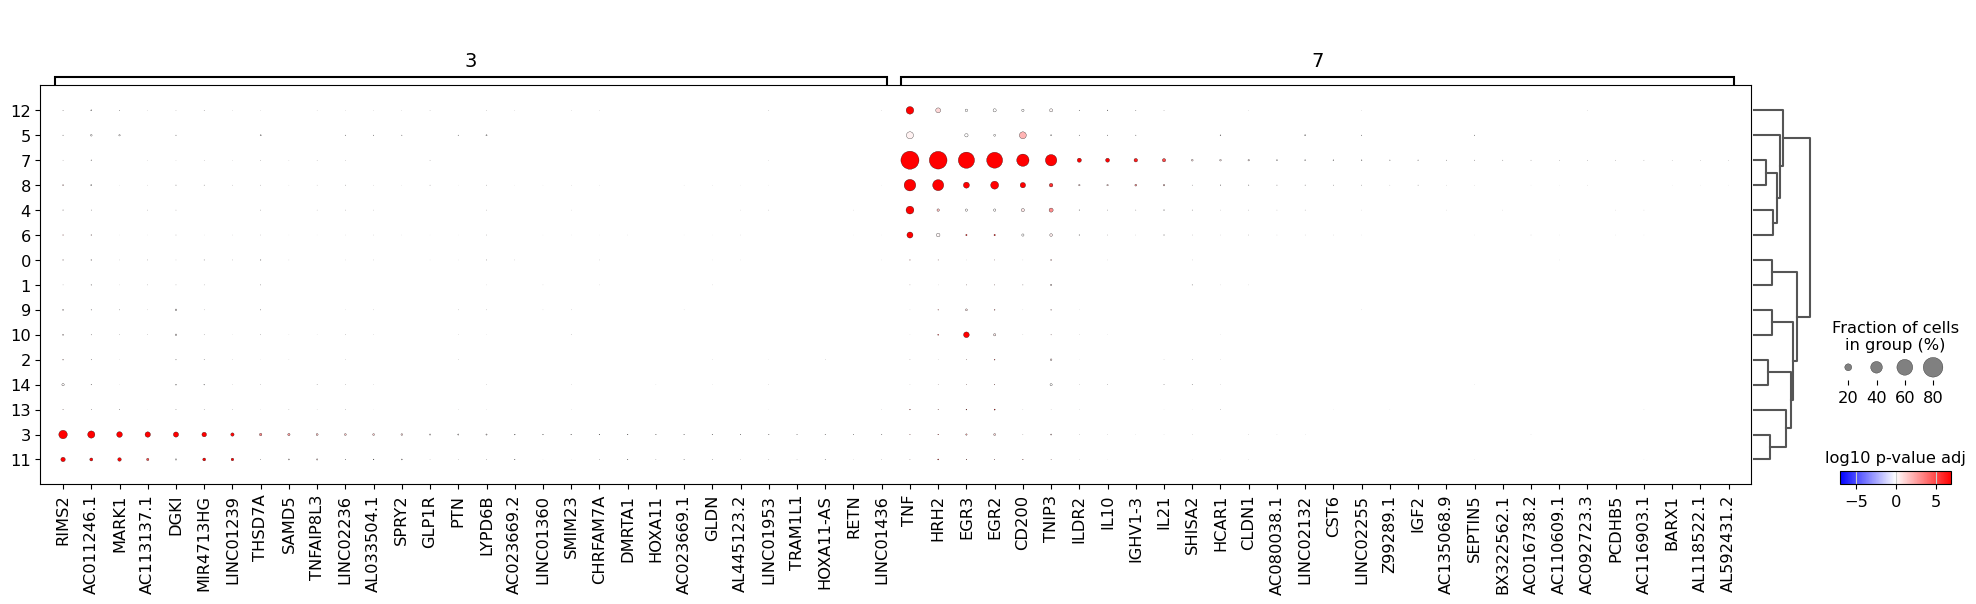

In [49]:
sc.pl.rank_genes_groups_dotplot(
    adata,
    n_genes=30,
    values_to_plot="log10_pvals_adj",
    min_logfoldchange=4,
    vmax=7,
    vmin=-7,
    cmap="bwr",
    groups=["3", "7"],
)

## Visualize marker genes using matrixplot

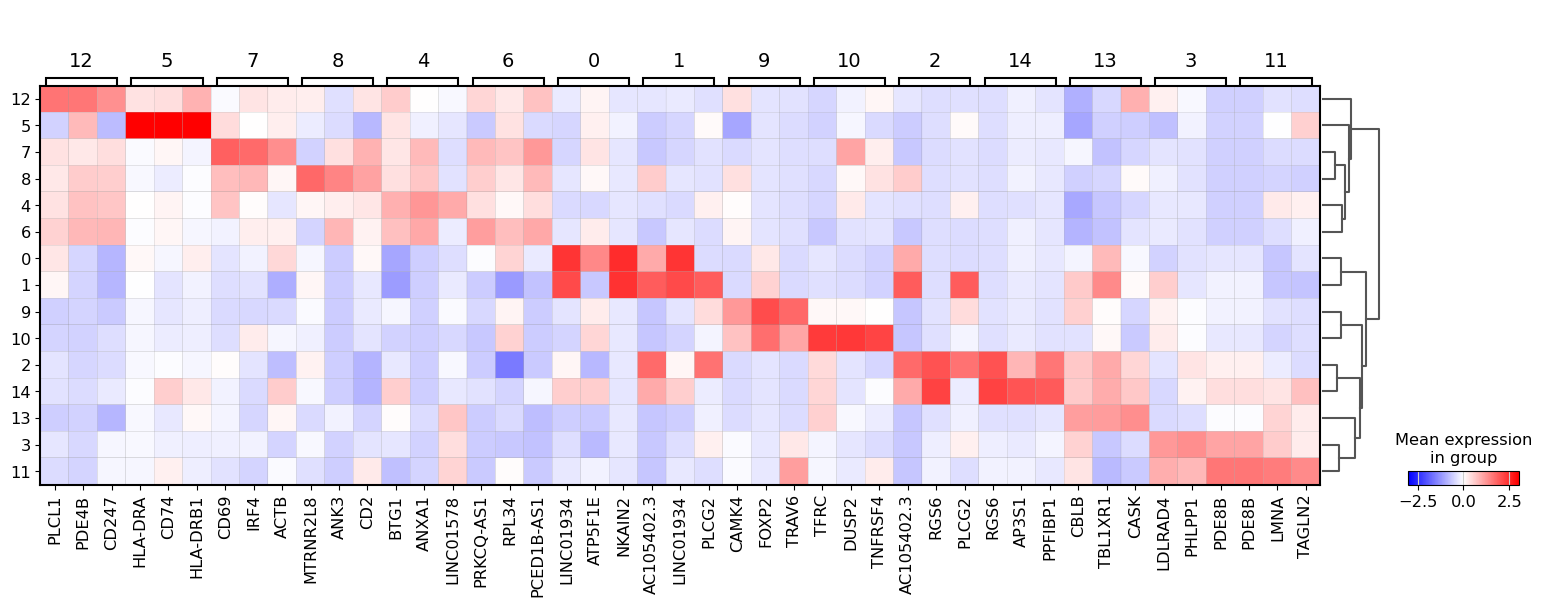

In [50]:
sc.pl.rank_genes_groups_matrixplot(
    adata, n_genes=3, use_raw=False, vmin=-3, vmax=3, cmap="bwr", layer="scaled"
)

## Visualize marker genes using stacked violin plots

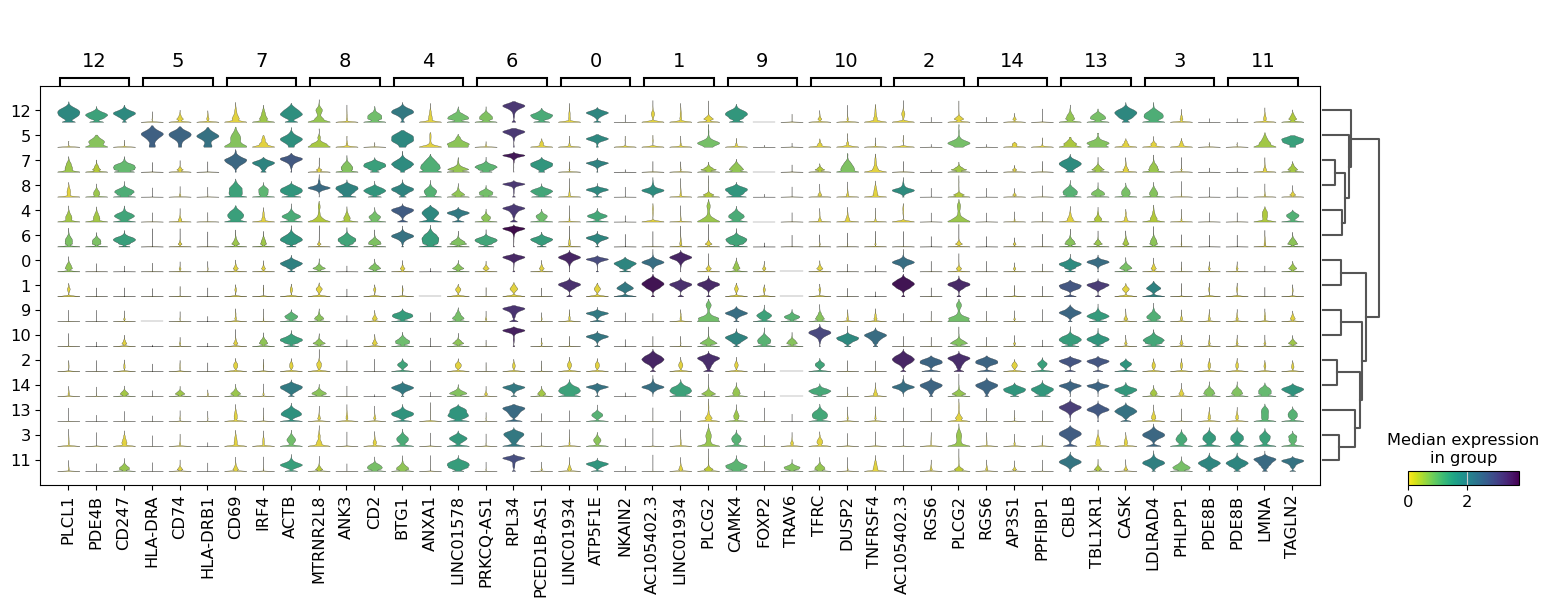

In [51]:
sc.pl.rank_genes_groups_stacked_violin(adata, n_genes=3, cmap="viridis_r")

## Visualize marker genes using heatmap

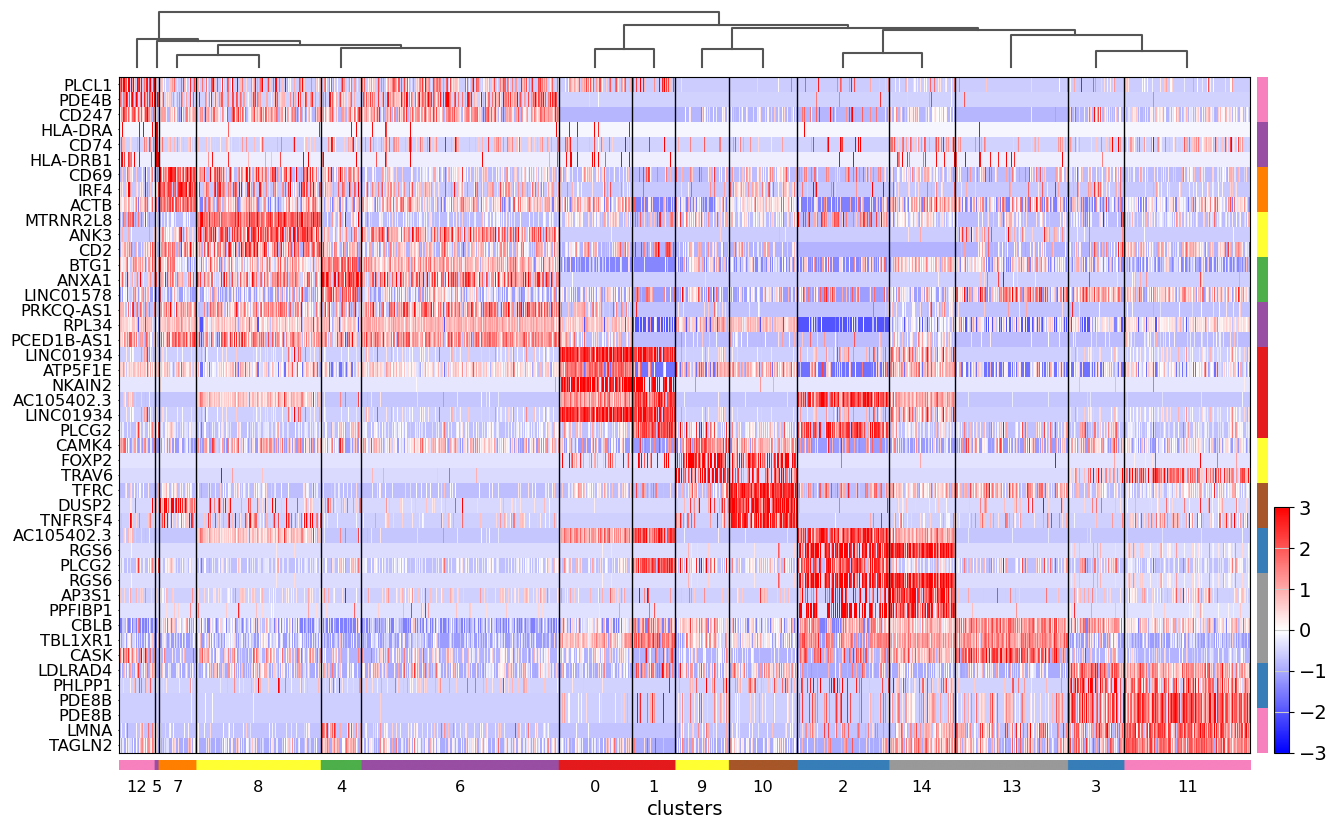

In [52]:
sc.pl.rank_genes_groups_heatmap(
    adata,
    n_genes=3,
    use_raw=False,
    swap_axes=True,
    vmin=-3,
    vmax=3,
    cmap="bwr",
    layer="scaled",
    figsize=(15, 10),
    show=False,
);

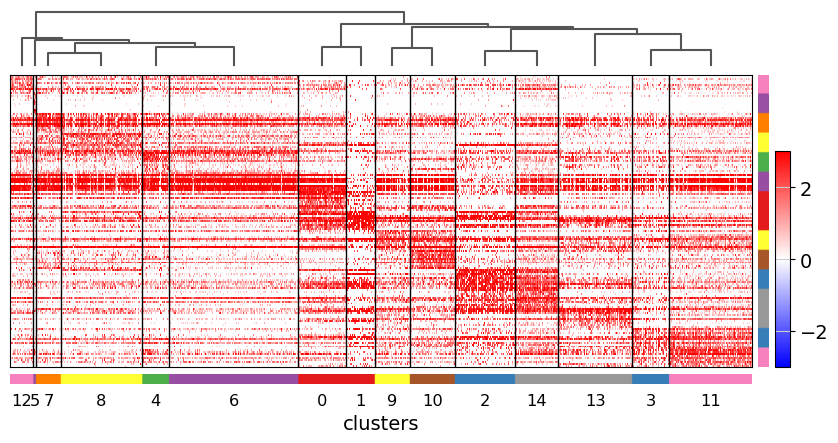

In [53]:
sc.pl.rank_genes_groups_heatmap(
    adata,
    n_genes=10,
    use_raw=False,
    swap_axes=True,
    show_gene_labels=False,
    vmin=-3,
    vmax=3,
    cmap="bwr",
)

## Visualize marker genes using tracksplot

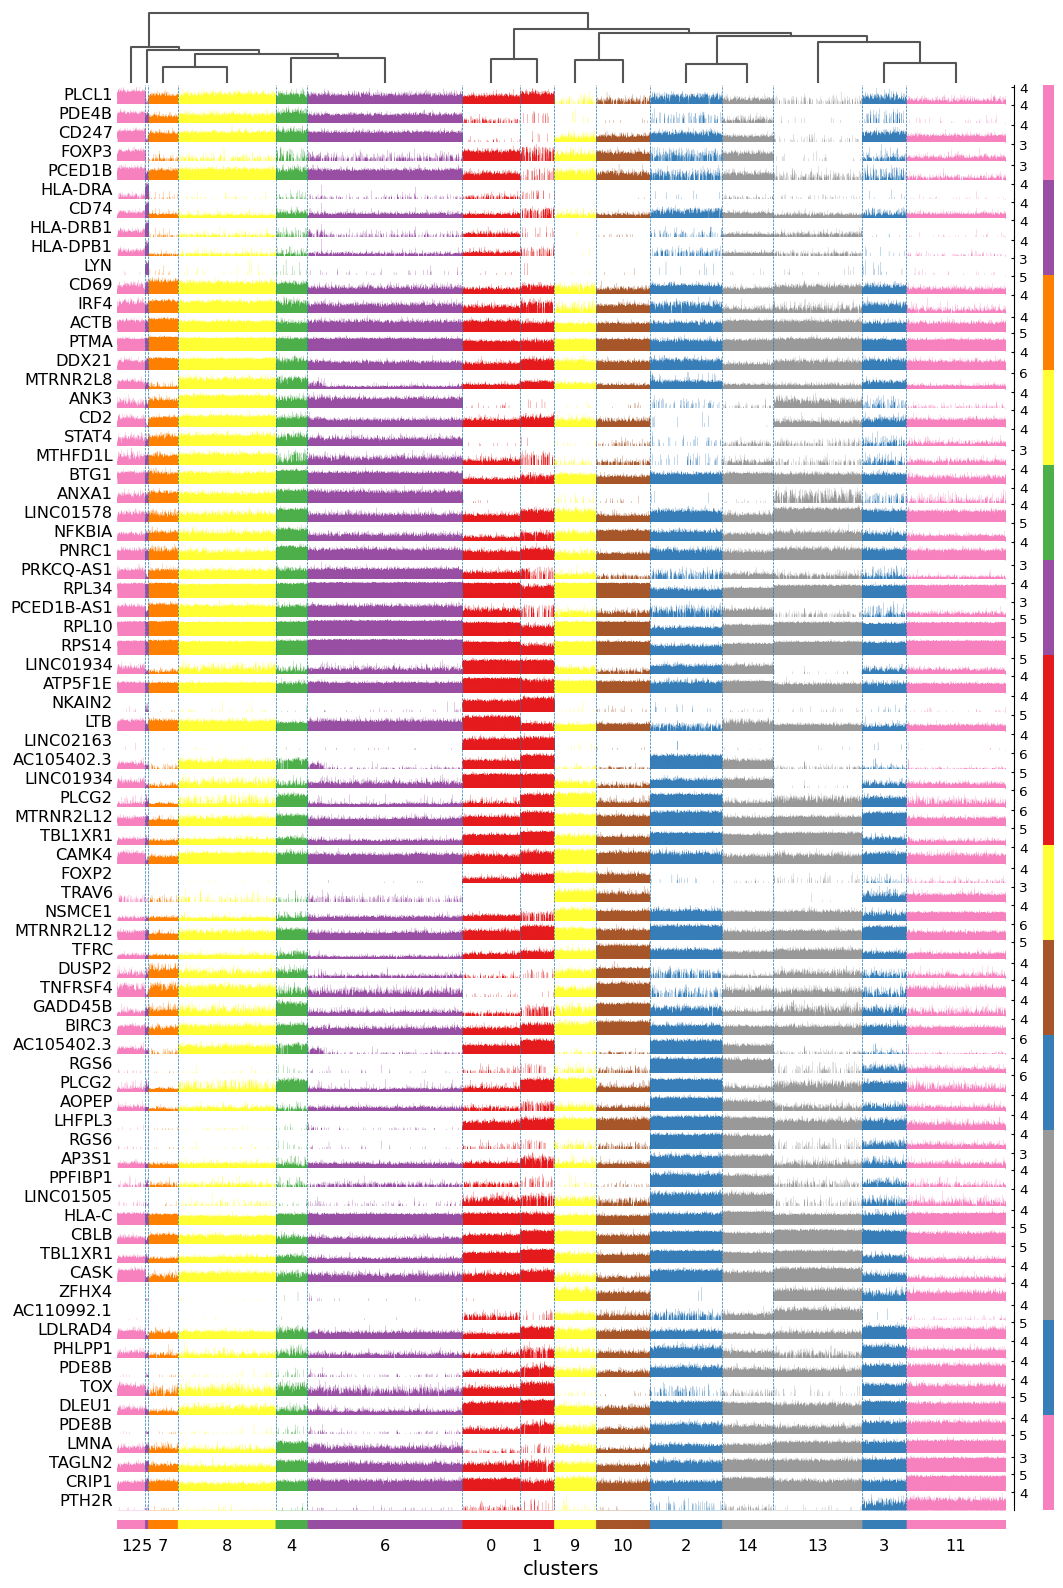

In [54]:
sc.pl.rank_genes_groups_tracksplot(adata, n_genes=5)

## Comparison of marker genes using split violin plots

/home/igris/py/lib/python3.12/site-packages/scanpy/plotting/_tools/__init__.py:1324: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ax.set_xticklabels(new_gene_names, rotation="vertical")


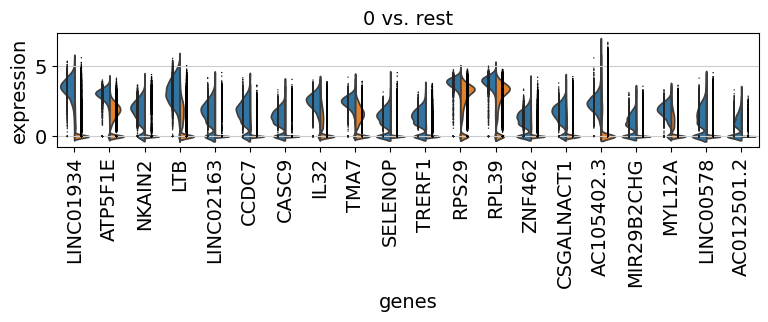

/home/igris/py/lib/python3.12/site-packages/scanpy/plotting/_tools/__init__.py:1324: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ax.set_xticklabels(new_gene_names, rotation="vertical")


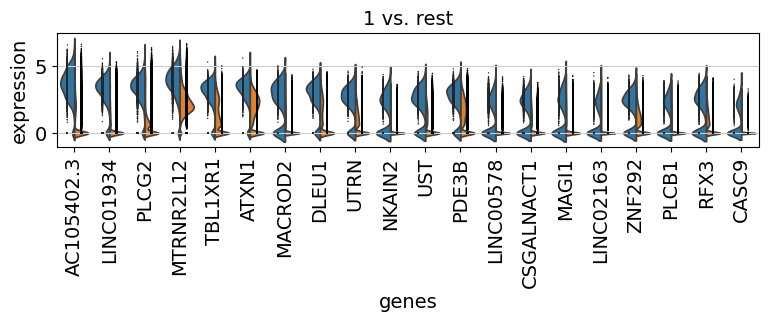

/home/igris/py/lib/python3.12/site-packages/scanpy/plotting/_tools/__init__.py:1324: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ax.set_xticklabels(new_gene_names, rotation="vertical")


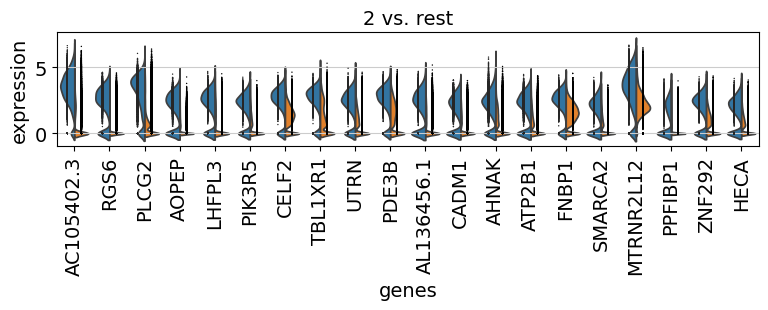

/home/igris/py/lib/python3.12/site-packages/scanpy/plotting/_tools/__init__.py:1324: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ax.set_xticklabels(new_gene_names, rotation="vertical")


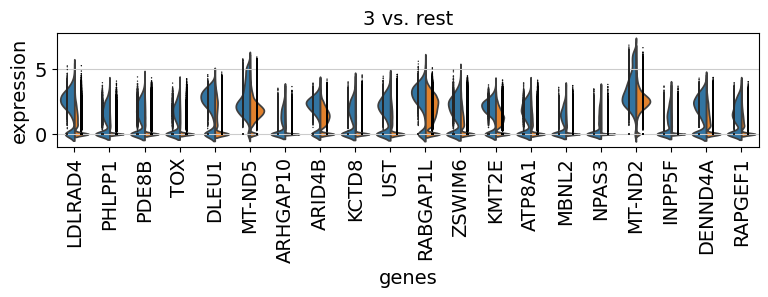

/home/igris/py/lib/python3.12/site-packages/scanpy/plotting/_tools/__init__.py:1324: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ax.set_xticklabels(new_gene_names, rotation="vertical")


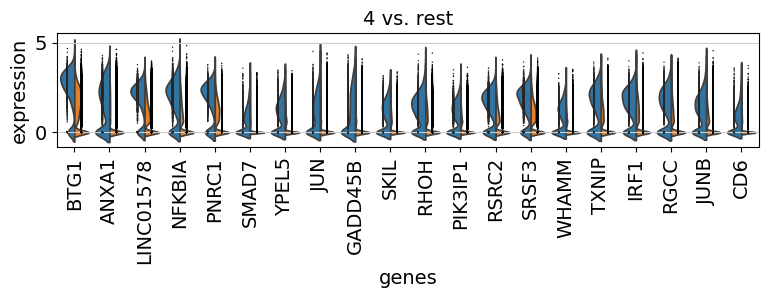

/home/igris/py/lib/python3.12/site-packages/scanpy/plotting/_tools/__init__.py:1324: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ax.set_xticklabels(new_gene_names, rotation="vertical")


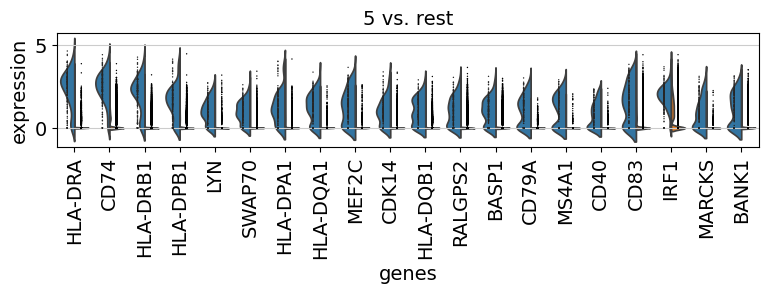

/home/igris/py/lib/python3.12/site-packages/scanpy/plotting/_tools/__init__.py:1324: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ax.set_xticklabels(new_gene_names, rotation="vertical")


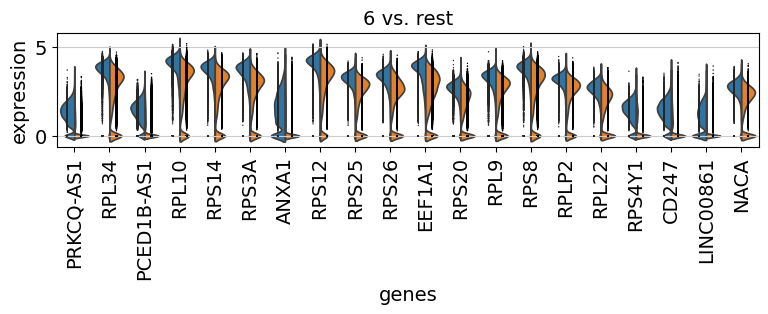

/home/igris/py/lib/python3.12/site-packages/scanpy/plotting/_tools/__init__.py:1324: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ax.set_xticklabels(new_gene_names, rotation="vertical")


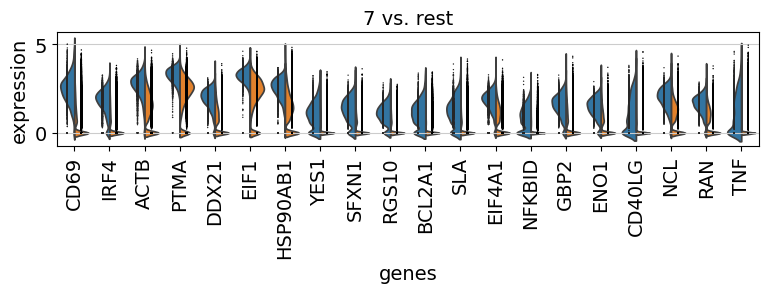

/home/igris/py/lib/python3.12/site-packages/scanpy/plotting/_tools/__init__.py:1324: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ax.set_xticklabels(new_gene_names, rotation="vertical")


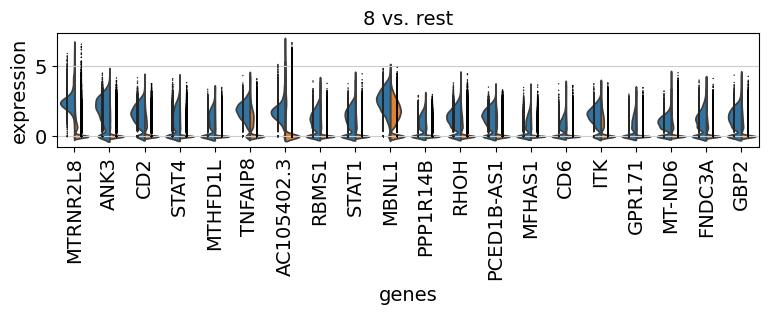

/home/igris/py/lib/python3.12/site-packages/scanpy/plotting/_tools/__init__.py:1324: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ax.set_xticklabels(new_gene_names, rotation="vertical")


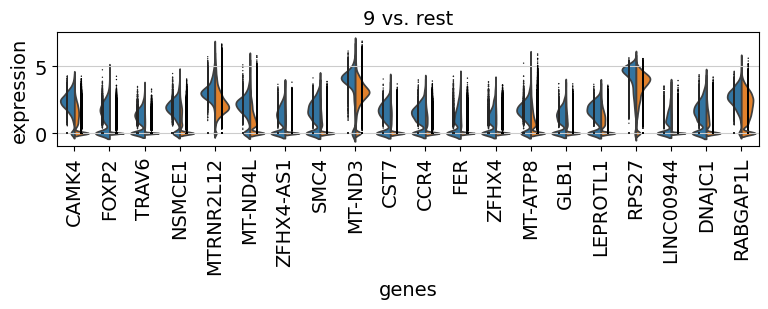

/home/igris/py/lib/python3.12/site-packages/scanpy/plotting/_tools/__init__.py:1324: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ax.set_xticklabels(new_gene_names, rotation="vertical")


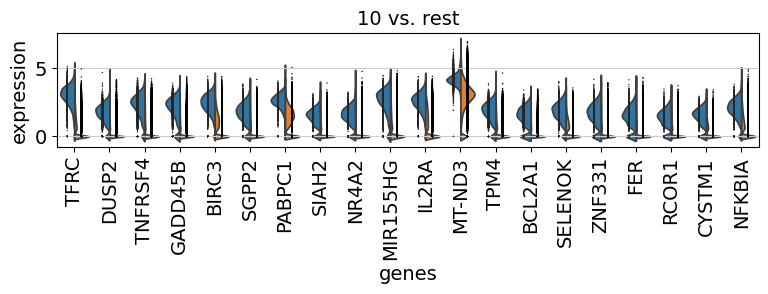

/home/igris/py/lib/python3.12/site-packages/scanpy/plotting/_tools/__init__.py:1324: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ax.set_xticklabels(new_gene_names, rotation="vertical")


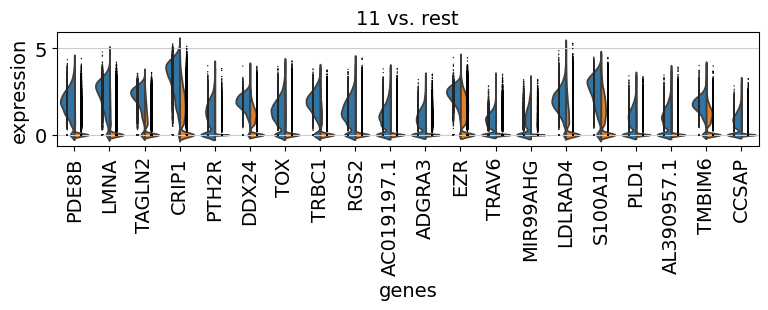

/home/igris/py/lib/python3.12/site-packages/scanpy/plotting/_tools/__init__.py:1324: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ax.set_xticklabels(new_gene_names, rotation="vertical")


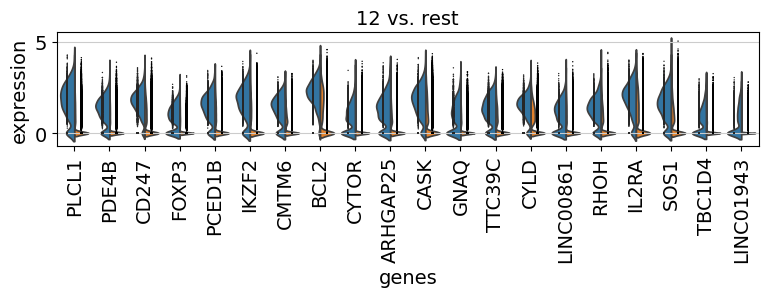

/home/igris/py/lib/python3.12/site-packages/scanpy/plotting/_tools/__init__.py:1324: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ax.set_xticklabels(new_gene_names, rotation="vertical")


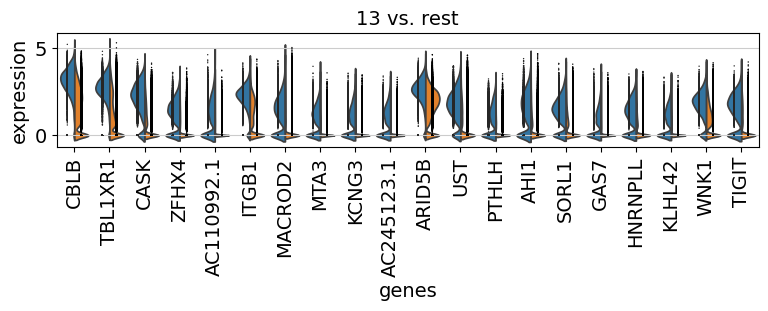

/home/igris/py/lib/python3.12/site-packages/scanpy/plotting/_tools/__init__.py:1324: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ax.set_xticklabels(new_gene_names, rotation="vertical")


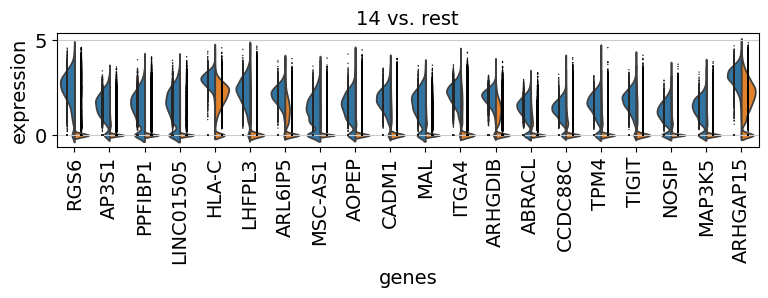

In [55]:
with rc_context({"figure.figsize": (9, 1.5)}):
    sc.pl.rank_genes_groups_violin(adata, n_genes=20, jitter=False)

## Dendrogram options

In [56]:
sc.tl.dendrogram(adata, "sample")

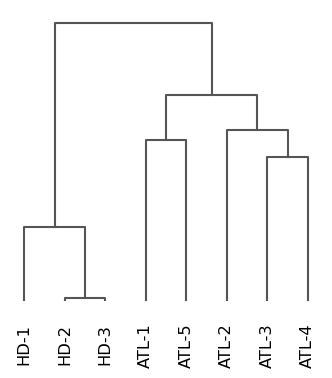

In [57]:
ax = sc.pl.dendrogram(adata, "sample")

## Plot correlation

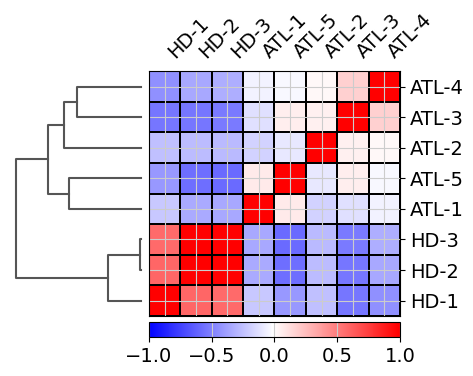

In [58]:
ax = sc.pl.correlation_matrix(adata, "sample", figsize=(5, 3.5))